Copyright 2018 The Dopamine Authors.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Dopamine: How to create and train a custom agent

This colab demonstrates how to create a variant of a provided agent (Example 1) and how to create a new agent from
scratch (Example 2).

Run all the cells below in order.

When running the following cell ("Install necessary packages") you will see a notice indicating that you need to restart your runtime. Hit restart, and then continue running the cells below it (from "Necessary imports and globals") onward.

In [ ]:
# !sudo apt update
# !sudo apt install -y python3-dev python3-pip build-essential libasound2-dev \
#                    libsdl2-dev libsdl2-image-dev libsdl2-mixer-dev \
#                    libsdl2-ttf-dev libsmpeg-dev libportmidi-dev libfreetype6-dev
!sudo apt update
!sudo apt install -y python3-dev python3-pip build-essential cmake \
                    libopenmpi-dev libglew-dev libgl1-mesa-dev libosmesa6-dev \
                    patchelf ffmpeg xvfb \
                    libsdl2-dev libsdl2-image-dev libsdl2-mixer-dev \
                    libsdl2-ttf-dev libsmpeg-dev libportmidi-dev libfreetype6-dev
!sudo apt-get install -y build-essential python3-dev python3-pip python3-venv
!sudo apt-get install -y libsdl2-dev libsdl2-image-dev libsdl2-mixer-dev libsdl2-ttf-dev


In [ ]:
# @title Install necessary packages.
!pip install -U dopamine-rl
!pip install -U gymnasium
!pip install -U ale_py

  Using cached baselines-0.1.5-py3-none-any.whl
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached zmq-0.0.0-py3-none-any.whl
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached progressbar2-4.5.0-py3-none-any.whl.metadata (16 kB)
  Using cached mpi4py-4.0.3.tar.gz (466 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
INFO: pip is looking at multiple versions of gym[atari,classic-control,mujoco,robotics] to determine which version is compatible with other requirements. This could take a while.
  Using cached gym-0.26.2-py3-none-any.whl
  Using cached ale_py-0.8.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  Preparing metadata (setup.py) ... done
  Using cached mujoco-2

['/home/zosov/anaconda3/envs/rl-project-dopamine/lib/python3.11/site-packages/mujoco']


In [1]:
# @title Necessary imports and globals.

import numpy as np
import os
from dopamine.jax.agents.dqn import dqn_agent
from dopamine.discrete_domains import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags
import gin

BASE_PATH = './logs'  # @param
GAME = 'Alien'  # @param

2025-03-27 12:14:04.966819: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 12:14:05.251878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743077645.355835      29 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743077645.384825      29 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 12:14:05.684930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Example 1: Train a modified version of DQN
Asterix is one of the standard agents provided with Dopamine.
The purpose of this example is to demonstrate how one can modify an existing agent. The modification
we are doing here (choosing actions randomly) is for illustrative purposes: it will clearly perform very
poorly.

In [2]:
import jax
import jax.numpy as jnp

# Check the default device JAX is using
print("JAX is using device:", jax.devices())

JAX is using device: [CudaDevice(id=0)]


In [9]:
# @title Create an agent based on DQN, but choosing actions randomly.

LOG_PATH = os.path.join(BASE_PATH, 'random_dqn', GAME)

class MyRandomDQNAgent(dqn_agent.JaxDQNAgent):
  def __init__(self, num_actions):
    """This maintains all the DQN default argument values."""
    super().__init__(num_actions)

  def step(self, reward, observation):
    """Calls the step function of the parent class, but returns a random action.
    """
    super().step(reward, observation)
    return np.random.randint(self.num_actions)

def create_random_dqn_agent(unused_sess, environment, summary_writer=None):
  """The Runner class will expect a function of this type to create an agent."""
  return MyRandomDQNAgent(num_actions=environment.action_space.n)

random_dqn_config = """
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
atari_lib.create_atari_environment.game_name = '{}'
atari_lib.create_atari_environment.sticky_actions = True
run_experiment.Runner.num_iterations = 200
run_experiment.Runner.training_steps = 10
run_experiment.Runner.max_steps_per_episode = 100
ReplayBuffer.max_capacity = 1_000
ReplayBuffer.batch_size = 32
""".format(GAME)
gin.parse_config(random_dqn_config, skip_unknown=False)

# Create the runner class with this agent. We use very small numbers of steps
# to terminate quickly, as this is mostly meant for demonstrating how one can
# use the framework.
random_dqn_runner = run_experiment.TrainRunner(LOG_PATH, create_random_dqn_agent)

In [ ]:
# @title Train MyRandomDQNAgent.
print('Will train agent, please be patient, may be a while...')
random_dqn_runner.run_experiment()
print('Done training!')

In [4]:
LOG_PATH = os.path.join(BASE_PATH, 'dqn', GAME)

def create_dqn_agent(unused_sess, environment, summary_writer=None):
  """The Runner class will expect a function of this type to create an agent."""
  return dqn_agent.JaxDQNAgent(num_actions=environment.action_space.n)

dqn_config = """
# Hyperparameters follow the classic Nature DQN, but we modify as necessary to
# match those used in Rainbow (Hessel et al., 2018), to ensure apples-to-apples
# comparison.
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
import dopamine.jax.agents.dqn.dqn_agent
import dopamine.jax.replay_memory.replay_buffer

JaxDQNAgent.gamma = 0.99
JaxDQNAgent.update_horizon = 1
JaxDQNAgent.min_replay_history = 20_000  # agent steps
JaxDQNAgent.update_period = 4
JaxDQNAgent.target_update_period = 8_000  # agent steps
JaxDQNAgent.epsilon_train = 0.01
JaxDQNAgent.epsilon_eval = 0.001
JaxDQNAgent.epsilon_decay_period = 250_000  # agent steps
# Note: We are using the Adam optimizer by default for JaxDQN, which differs
#       from the original NatureDQN and the dopamine TensorFlow version. In
#       the experiments we have ran, we have found that using Adam yields
#       improved training performance.
JaxDQNAgent.optimizer = 'adam'
create_optimizer.learning_rate = 6.25e-5
create_optimizer.eps = 1.5e-4

atari_lib.create_atari_environment.game_name = 'Pong'
# Sticky actions with probability 0.25, as suggested by (Machado et al., 2017).
atari_lib.create_atari_environment.sticky_actions = True
create_runner.schedule = 'continuous_train'
create_agent.agent_name = 'jax_dqn'
create_agent.debug_mode = True
Runner.num_iterations = 1
Runner.training_steps = 250_000  # agent steps
Runner.evaluation_steps = 125_000  # agent steps
Runner.max_steps_per_episode = 27_000  # agent steps

ReplayBuffer.max_capacity = 1_000_000
ReplayBuffer.batch_size = 32
""".format(GAME)
gin.parse_config(dqn_config, skip_unknown=False)

# Create the runner class with this agent. We use very small numbers of steps
# to terminate quickly, as this is mostly meant for demonstrating how one can
# use the framework.

dqn_runner = run_experiment.TrainRunner(LOG_PATH, create_dqn_agent)

In [13]:
!pip uninstall -y jax jaxlib

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1


In [14]:
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 6.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 7.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 MB 3.6 MB/s eta 0:00:0000:010:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 5.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82


In [1]:
import jax
print("JAX devices:", jax.devices())

JAX devices: [CudaDevice(id=0)]


In [15]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


In [5]:
# @title Train MyRandomDQNAgent.
# Measure the training time.
import time
start_time = time.time()
print('Will train agent, please be patient, may be a while...')
dqn_runner.run_experiment()
print('Done training!')
print('Training time: {:.2f} sec'.format(time.time() - start_time))


Will train agent, please be patient, may be a while...


  0%|                                                                                                      | 0/1 [00:00<?, ?it/s]WARNING:absl:Got kwargs {'priority': None} to `UniformDistribution.add`, ignoring...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [15:01<00:00, 901.30s/it]

Done training!
Training time: 901.33 sec


In [9]:
# @title Load the training logs.
random_dqn_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
random_dqn_data['agent'] = 'MyRandomDQN'
random_dqn_data['run_number'] = 1
experimental_data = {GAME:  random_dqn_data}


Reading statistics from: ./logs/random_dqn/Asterix//logs/log_399


In [11]:
!pip install seaborn

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 773.9 kB/s eta 0:00:00 0:00:01


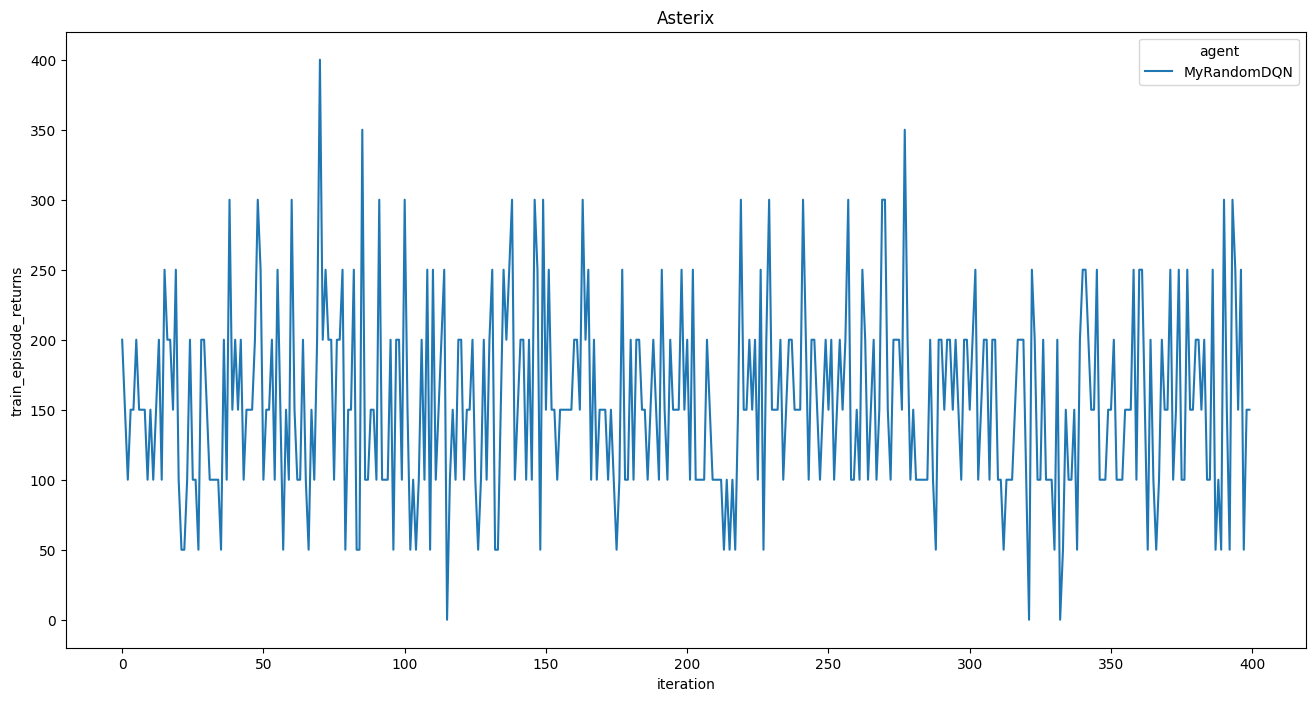

In [12]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(
    x='iteration', y='train_episode_returns', hue='agent',
    data=experimental_data[GAME], ax=ax)
plt.title(GAME)
plt.show()

## Example 2: Train an agent built from scratch.
The purpose of this example is to demonstrate how one can create an agent from scratch. The agent
created here is meant to demonstrate the bare minimum functionality that is expected from agents. It is
selecting actions in a very suboptimal way, so it will clearly do poorly.

In [13]:
# @title Create a completely new agent from scratch.

LOG_PATH = os.path.join(BASE_PATH, 'sticky_agent', GAME)

class StickyAgent(object):
  """This agent randomly selects an action and sticks to it. It will change
  actions with probability switch_prob."""
  def __init__(self, sess, num_actions, switch_prob=0.1):
    self._sess = sess
    self.summary_writer = None
    self._num_actions = num_actions
    self._switch_prob = switch_prob
    self._last_action = np.random.randint(num_actions)
    self.eval_mode = False

  def _choose_action(self):
    if np.random.random() <= self._switch_prob:
      self._last_action = np.random.randint(self._num_actions)
    return self._last_action

  def bundle_and_checkpoint(self, checkpoint_dir, iteration):
    del checkpoint_dir, iteration  # Unused.

  def unbundle(self, checkpoint_dir, checkpoint_version, data):
    del checkpoint_dir, checkpoint_version, data  # Unused.

  def begin_episode(self, observation):
    del observation  # Unused.
    return self._choose_action()

  def end_episode(self, reward):
    del reward  # Unused.

  def step(self, reward, observation):
    return self._choose_action()

def create_sticky_agent(sess, environment, summary_writer=None):
  """The Runner class will expect a function of this type to create an agent."""
  return StickyAgent(sess, num_actions=environment.action_space.n,
                     switch_prob=0.2)

sticky_config = """
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
atari_lib.create_atari_environment.game_name = '{}'
atari_lib.create_atari_environment.sticky_actions = True
run_experiment.Runner.num_iterations = 200
run_experiment.Runner.training_steps = 10
run_experiment.Runner.max_steps_per_episode = 100
ReplayBuffer.max_capacity = 1_000
ReplayBuffer.batch_size = 32
""".format(GAME)
gin.parse_config(sticky_config, skip_unknown=False)

# Create the runner class with this agent. We use very small numbers of steps
# to terminate quickly, as this is mostly meant for demonstrating how one can
# use the framework.
sticky_runner = run_experiment.TrainRunner(LOG_PATH, create_sticky_agent)

In [14]:
# @title Train StickyAgent.
print('Will train sticky agent, please be patient, may be a while...')
sticky_runner.run_experiment()
print('Done training!')

Will train sticky agent, please be patient, may be a while...


  0%|                                                                                                    | 0/200 [00:00<?, ?it/s]

  0%|▍                                                                                           | 1/200 [00:00<00:23,  8.58it/s]

  2%|█▊                                                                                          | 4/200 [00:00<00:11, 16.46it/s]

  4%|███▏                                                                                        | 7/200 [00:00<00:10, 18.65it/s]

  5%|████▌                                                                                      | 10/200 [00:00<00:09, 19.55it/s]

  6%|█████▉                                                                                     | 13/200 [00:00<00:09, 20.05it/s]

  8%|██████▊                                                                                    | 15/200 [00:00<00:09, 19.64it/s]

  9%|████████▏                                                                                  | 18/200 [00:00<00:09, 19.98it/s]

 10%|█████████▌                                                                                 | 21/200 [00:01<00:08, 20.22it/s]

 12%|██████████▉                                                                                | 24/200 [00:01<00:08, 20.32it/s]

 14%|████████████▎                                                                              | 27/200 [00:01<00:08, 20.57it/s]

 15%|█████████████▋                                                                             | 30/200 [00:01<00:08, 20.17it/s]

 16%|███████████████                                                                            | 33/200 [00:01<00:08, 20.38it/s]

 18%|████████████████▍                                                                          | 36/200 [00:01<00:08, 20.40it/s]

 20%|█████████████████▋                                                                         | 39/200 [00:01<00:07, 20.46it/s]

 21%|███████████████████                                                                        | 42/200 [00:02<00:07, 20.56it/s]

 22%|████████████████████▍                                                                      | 45/200 [00:02<00:07, 20.64it/s]

 24%|█████████████████████▊                                                                     | 48/200 [00:02<00:07, 20.62it/s]

 26%|███████████████████████▏                                                                   | 51/200 [00:02<00:07, 20.76it/s]

 27%|████████████████████████▌                                                                  | 54/200 [00:02<00:07, 20.63it/s]

 28%|█████████████████████████▉                                                                 | 57/200 [00:02<00:06, 20.61it/s]

 30%|███████████████████████████▎                                                               | 60/200 [00:02<00:06, 20.76it/s]

 32%|████████████████████████████▋                                                              | 63/200 [00:03<00:06, 20.62it/s]

 33%|██████████████████████████████                                                             | 66/200 [00:03<00:06, 20.88it/s]

 34%|███████████████████████████████▍                                                           | 69/200 [00:03<00:06, 21.08it/s]

 36%|████████████████████████████████▊                                                          | 72/200 [00:03<00:06, 21.17it/s]

 38%|██████████████████████████████████▏                                                        | 75/200 [00:03<00:05, 21.17it/s]

 39%|███████████████████████████████████▍                                                       | 78/200 [00:03<00:05, 21.18it/s]

 40%|████████████████████████████████████▊                                                      | 81/200 [00:03<00:05, 21.18it/s]

 42%|██████████████████████████████████████▏                                                    | 84/200 [00:04<00:05, 20.96it/s]

 44%|███████████████████████████████████████▌                                                   | 87/200 [00:04<00:05, 20.75it/s]

 45%|████████████████████████████████████████▉                                                  | 90/200 [00:04<00:05, 20.77it/s]

 46%|██████████████████████████████████████████▎                                                | 93/200 [00:04<00:05, 20.61it/s]

 48%|███████████████████████████████████████████▋                                               | 96/200 [00:04<00:04, 20.82it/s]

 50%|█████████████████████████████████████████████                                              | 99/200 [00:04<00:04, 20.89it/s]

 51%|█████████████████████████████████████████████▉                                            | 102/200 [00:04<00:04, 20.92it/s]

 52%|███████████████████████████████████████████████▎                                          | 105/200 [00:05<00:04, 21.03it/s]

 54%|████████████████████████████████████████████████▌                                         | 108/200 [00:05<00:04, 21.01it/s]

 56%|█████████████████████████████████████████████████▉                                        | 111/200 [00:05<00:04, 20.96it/s]

 57%|███████████████████████████████████████████████████▎                                      | 114/200 [00:05<00:04, 20.63it/s]

 58%|████████████████████████████████████████████████████▋                                     | 117/200 [00:05<00:04, 20.57it/s]

 60%|██████████████████████████████████████████████████████                                    | 120/200 [00:05<00:03, 20.66it/s]

 62%|███████████████████████████████████████████████████████▎                                  | 123/200 [00:05<00:03, 20.70it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 126/200 [00:06<00:03, 20.86it/s]

 64%|██████████████████████████████████████████████████████████                                | 129/200 [00:06<00:03, 20.96it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 132/200 [00:06<00:03, 20.80it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 135/200 [00:06<00:03, 20.63it/s]

 69%|██████████████████████████████████████████████████████████████                            | 138/200 [00:06<00:03, 20.61it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 141/200 [00:06<00:02, 20.52it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 144/200 [00:07<00:02, 20.19it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 147/200 [00:07<00:02, 20.53it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 150/200 [00:07<00:02, 20.71it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 153/200 [00:07<00:02, 20.52it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 156/200 [00:07<00:02, 20.73it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 159/200 [00:07<00:01, 20.75it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 162/200 [00:07<00:01, 20.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎               | 165/200 [00:08<00:01, 20.60it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 168/200 [00:08<00:01, 21.00it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 171/200 [00:08<00:01, 20.97it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 174/200 [00:08<00:01, 20.60it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋          | 177/200 [00:08<00:01, 20.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 180/200 [00:08<00:00, 20.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▎       | 183/200 [00:08<00:00, 20.79it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 186/200 [00:09<00:00, 20.93it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 189/200 [00:09<00:00, 20.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 192/200 [00:09<00:00, 20.89it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 195/200 [00:09<00:00, 21.27it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 198/200 [00:09<00:00, 21.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 20.64it/s]

Done training!


In [15]:
# @title Load the training logs.
sticky_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
sticky_data['agent'] = 'StickyAgent'
sticky_data['run_number'] = 1
experimental_data[GAME] = experimental_data[GAME].merge(sticky_data,
                                                        how='outer')

Reading statistics from: ./logs/sticky_agent/Asterix//logs/log_199


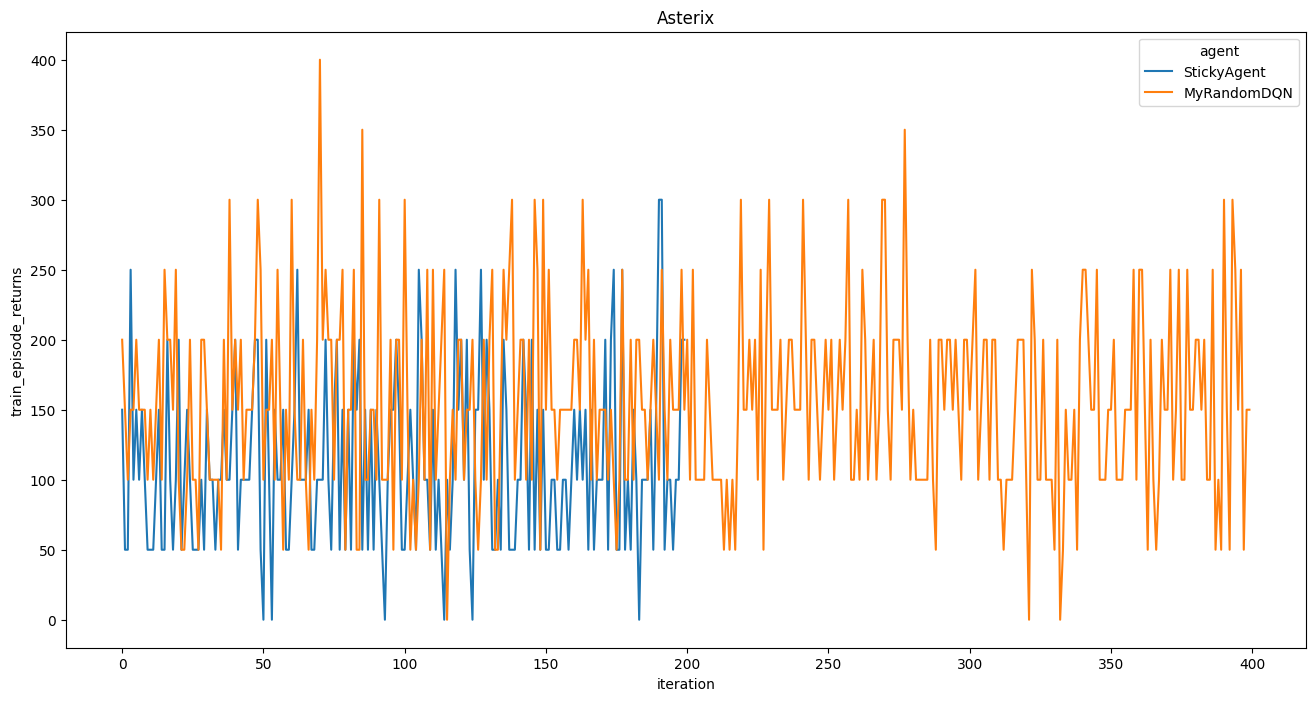

In [16]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(
    x='iteration', y='train_episode_returns', hue='agent',
    data=experimental_data[GAME], ax=ax)
plt.title(GAME)
plt.show()